## <small>
Copyright (c) 2017-21 Andrew Glassner

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>



# Deep Learning: A Visual Approach
## by Andrew Glassner, https://glassner.com
### Order: https://nostarch.com/deep-learning-visual-approach
### GitHub: https://github.com/blueberrymusic
------

### What's in this notebook

This notebook is provided to help you work with Keras and TensorFlow. It accompanies the bonus chapters for my book. The code is in Python3, using the versions of libraries as of April 2021.

Note that I've included the output cells in this saved notebook, but Jupyter doesn't save the variables or data that were used to generate them. To recreate any cell's output, evaluate all the cells from the start up to that cell. A convenient way to experiment is to first choose "Restart & Run All" from the Kernel menu, so that everything's been defined and is up to date. Then you can experiment using the variables, data, functions, and other stuff defined in this notebook.


## Bonus Chapter 3 - Notebook 2: Improving the model

In [1]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.constraints import maxnorm
import h5py
import numpy as np

from keras import backend as keras_backend
keras_backend.set_image_data_format('channels_last')

Using TensorFlow backend.


In [2]:
# Workaround for Keras issues on Mac computers (you can comment this
# out if you're not on a Mac, or not having problems)
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
# Make a File_Helper for saving and loading files.

save_files = False

import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0, os.path.dirname(current_dir)) # path to parent dir
from DLBasics_Utilities import File_Helper
file_helper = File_Helper(save_files)

In [4]:
# Load and process the MNIST data

random_seed = 42

# load the MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
image_height = X_train.shape[1]
image_width = X_train.shape[2]
number_of_pixels = image_height * image_width

# cast the sample data to the current Keras floating-point type
X_train = keras_backend.cast_to_floatx(X_train)
X_test = keras_backend.cast_to_floatx(X_test)

# scale data to range [0, 1]
X_train /= 255.0
X_test /= 255.0

# save labels in their non-one-hot form
original_y_train = np.copy(y_train)
original_y_test = np.copy(y_test)

# replace label data with one-hot encoded versions
number_of_classes = 1 + max(np.append(y_train, y_test))
y_train = np_utils.to_categorical(y_train, number_of_classes)
y_test = np_utils.to_categorical(y_test, number_of_classes)

# reshape to 2D grid, one line per image
X_train = X_train.reshape(X_train.shape[0], number_of_pixels)
X_test = X_test.reshape(X_test.shape[0], number_of_pixels)

In [5]:
# These variables are assigned during our pre-processing step. 
# We'll just assign them directly here for this demonstration.
number_of_pixels = 28*28  # size of an MNIST image
number_of_classes = 10    # MNIST images are digits 0 to 9

def make_one_hidden_layer_model():
    # create an empty model
    model = Sequential()
    # add a fully-connected hidden layer with #nodes = #pixels
    model.add(Dense(number_of_pixels, activation='relu',
                    input_shape=[number_of_pixels]))
    # add an output layer with softmax activation
    model.add(Dense(number_of_classes, activation='softmax'))
    # compile the model to turn it from specification to code
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=['accuracy'])
    return model

In [6]:
def make_two_hidden_layers_model():
    model = Sequential()
    model.add(Dense(number_of_pixels, input_shape=[number_of_pixels], 
                    activation='relu'))
    model.add(Dense(number_of_pixels, activation='relu'))
    model.add(Dense(number_of_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def make_hidden_layer_n_neurons(num_neurons):
    model = Sequential()
    model.add(Dense(num_neurons, input_shape=[number_of_pixels], 
                    activation='relu'))
    model.add(Dense(number_of_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# make a general model of any number of dense layers, each optionally followed by dropout
def make_layers_model(neurons_per_layer, dropout_per_layer, learning_rate=0.001):
    model = Sequential()
    for i in range(len(neurons_per_layer)):
        kwargs = { 'kernel_initializer': 'normal', 'activation': 'relu' }
        if i==0:
            kwargs['input_dim'] = number_of_pixels
        if dropout_per_layer[i]:
            kwargs['kernel_constraint'] = maxnorm(3)
        model.add(Dense(neurons_per_layer[i], **kwargs))
        if dropout_per_layer[i]:
            model.add(Dropout(0.2))
    model.add(Dense(number_of_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=learning_rate), metrics=['accuracy'])
    return model

In [7]:
# A little utility to draw accuracy and loss plots
import matplotlib.pyplot as plt

def plot_accuracy_and_loss(history, plot_title, filename):
    xs = range(len(history.history['accuracy']))
    # manually change legend location to 'best' when the locations
    # here don't look good. 

    plt.figure(figsize=(10,3))
    plt.subplot(1, 2, 1)
    plt.plot(xs, history.history['accuracy'], label='train')
    plt.plot(xs, history.history['val_accuracy'], label='validation')
    plt.legend(loc='lower left')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title(plot_title+', Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(xs, history.history['loss'], label='train')
    plt.plot(xs, history.history['val_loss'], label='validation')
    plt.legend(loc='upper left')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title(plot_title+', Loss')

    #plt.tight_layout()
    file_helper.save_figure(filename)
    plt.show()

In [8]:
# A utility to let us try out lots of variations of models,
# batch size, and early stopping, and plot and save the results.
#
# We use Python's kwargs mechanism as a way to package up the parameters
# to a function in a dictionary. It's a little fancy but it saves a huge
# amount of code. See the Python docs for how this feature works.
#   

def run_and_report(model, plot_title=None, filename='generic-filename', 
                   epochs=100, batch_size=256, verbosity=2, stop_early=False):
    np.random.seed(random_seed)
    kwargs = { 'validation_data': (X_test, y_test), 'epochs': epochs,
              'batch_size': batch_size, 'verbose': verbosity }
    if stop_early:
        early_stopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
        kwargs['callbacks'] = [early_stopper]
    history = model.fit(X_train, y_train, **kwargs)
    plot_accuracy_and_loss(history, plot_title, filename)
    models_folder_name = 'NB09-checkpointed-models'
    file_helper.check_for_directory(models_folder_name)

    filename = models_folder_name+'/'+filename+'-'+str(epochs)+'-epochs.h5'
    model.save(filename)
    return history

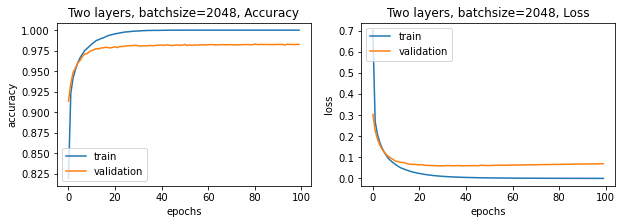

batchsize  2048  elapsed time= 148.05094599723816


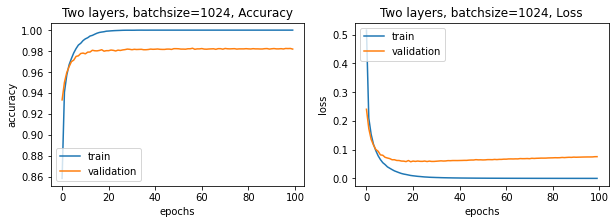

batchsize  1024  elapsed time= 174.18409490585327


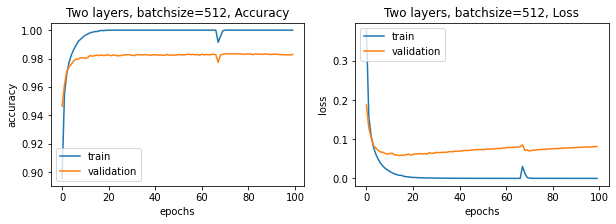

batchsize  512  elapsed time= 222.61101484298706


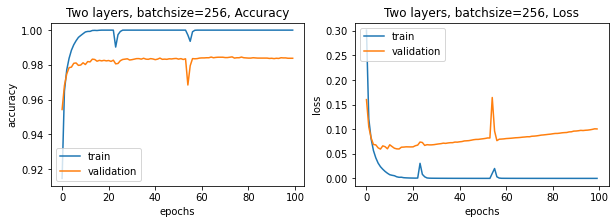

batchsize  256  elapsed time= 328.39921712875366


In [9]:
#
# WARNING: If you're training on a CPU (that is, without a GPU),
# then as batch sizes decrease, running time increases FAST.
# Without a GPU, be careful with batch sizes smaller than 256.
# I'm using big batches here so the notebook runs in less than a
# few days. If you have a fast machine and/or a great GPU, it would
# be instructive to include more sizes, as in the commented definition
# of batch_sizes.
#
import time
history_list = []
time_list = []

#batch_sizes = [2048, 1024, 512, 256, 128, 64, 32, 16, 8]
batch_sizes = [2048, 1024, 512, 256]
for batchsize in batch_sizes:
    model = make_one_hidden_layer_model()
    plot_title = 'Two layers, batchsize='+str(batchsize)
    filename = 'two-layers-batch-'+str(batchsize)
    start_time = time.time()
    history = run_and_report(model, plot_title, filename, batch_size=batchsize, verbosity=0)
    end_time = time.time()
    elapsed_time = end_time-start_time
    history_list.append(history)
    print("batchsize ",batchsize," elapsed time=",elapsed_time)
    time_list.append(elapsed_time)

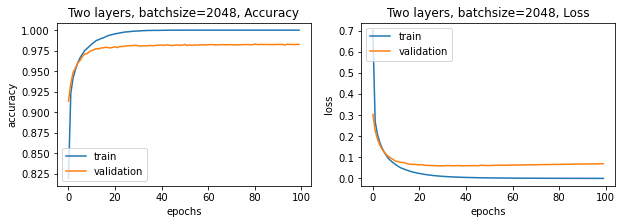

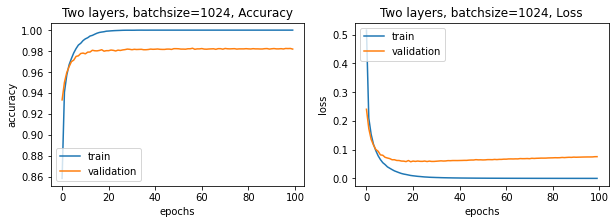

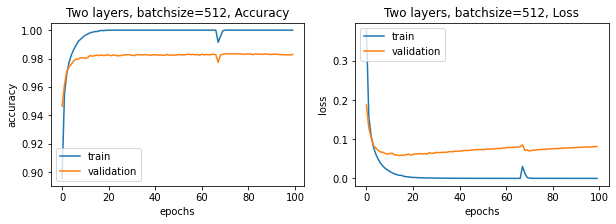

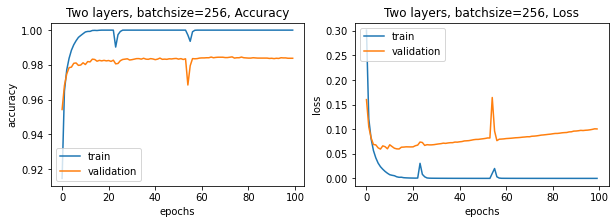

In [10]:
plot_accuracy_and_loss(history_list[0], 'Two layers, batchsize=2048', 'two-layers-batch-2048')
plot_accuracy_and_loss(history_list[1], 'Two layers, batchsize=1024', 'two-layers-batch-1024')
plot_accuracy_and_loss(history_list[2], 'Two layers, batchsize=512', 'two-layers-batch-512')
plot_accuracy_and_loss(history_list[3], 'Two layers, batchsize=256', 'two-layers-batch-256')

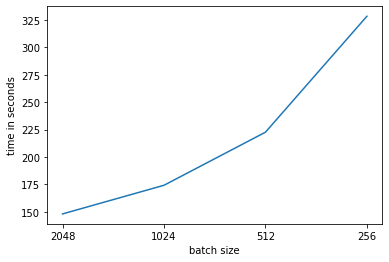

In [12]:
plt.plot(range(len(time_list)), time_list)
plt.xlabel('batch size')
plt.ylabel('time in seconds')
plt.xticks(range(len(time_list)), batch_sizes)
file_helper.save_figure('batch-timing')
plt.show()

In [13]:
# A better size is 256, but that takes a LONG time to run!
comparison_batch_size = 1024

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
 - 4s - loss: 0.4123 - accuracy: 0.8833 - val_loss: 0.1765 - val_accuracy: 0.9477
Epoch 2/100
 - 3s - loss: 0.1347 - accuracy: 0.9602 - val_loss: 0.1093 - val_accuracy: 0.9658
Epoch 3/100
 - 3s - loss: 0.0865 - accuracy: 0.9747 - val_loss: 0.0856 - val_accuracy: 0.9728
Epoch 4/100
 - 3s - loss: 0.0585 - accuracy: 0.9829 - val_loss: 0.0729 - val_accuracy: 0.9765
Epoch 5/100
 - 3s - loss: 0.0418 - accuracy: 0.9883 - val_loss: 0.0697 - val_accuracy: 0.9768
Epoch 6/100
 - 3s - loss: 0.0296 - accuracy: 0.9918 - val_loss: 0.0612 - val_accuracy: 0.9804
Epoch 7/100
 - 3s - loss: 0.0197 - accuracy: 0.9949 - val_loss: 0.0648 - val_accuracy: 0.9798
Epoch 8/100
 - 3s - loss: 0.0152 - accuracy: 0.9964 - val_loss: 0.0674 - val_accuracy: 0.9781
Epoch 9/100
 - 3s - loss: 0.0116 - accuracy: 0.9973 - val_loss: 0.0624 - val_accuracy: 0.9803
Epoch 10/100
 - 3s - loss: 0.0079 - accuracy: 0.9985 - val_loss: 0.0620 - val_accuracy: 0.9812
Epoch 11/

Epoch 84/100
 - 3s - loss: 7.8867e-06 - accuracy: 1.0000 - val_loss: 0.0945 - val_accuracy: 0.9833
Epoch 85/100
 - 3s - loss: 7.5030e-06 - accuracy: 1.0000 - val_loss: 0.0948 - val_accuracy: 0.9835
Epoch 86/100
 - 3s - loss: 7.2236e-06 - accuracy: 1.0000 - val_loss: 0.0951 - val_accuracy: 0.9834
Epoch 87/100
 - 3s - loss: 6.8848e-06 - accuracy: 1.0000 - val_loss: 0.0956 - val_accuracy: 0.9833
Epoch 88/100
 - 3s - loss: 6.6238e-06 - accuracy: 1.0000 - val_loss: 0.0957 - val_accuracy: 0.9833
Epoch 89/100
 - 3s - loss: 6.3390e-06 - accuracy: 1.0000 - val_loss: 0.0961 - val_accuracy: 0.9833
Epoch 90/100
 - 3s - loss: 6.0371e-06 - accuracy: 1.0000 - val_loss: 0.0965 - val_accuracy: 0.9833
Epoch 91/100
 - 3s - loss: 5.8021e-06 - accuracy: 1.0000 - val_loss: 0.0968 - val_accuracy: 0.9833
Epoch 92/100
 - 3s - loss: 5.5600e-06 - accuracy: 1.0000 - val_loss: 0.0971 - val_accuracy: 0.9833
Epoch 93/100
 - 3s - loss: 5.3270e-06 - accuracy: 1.0000 - val_loss: 0.0974 - val_accuracy: 0.9832
Epoch 94/1

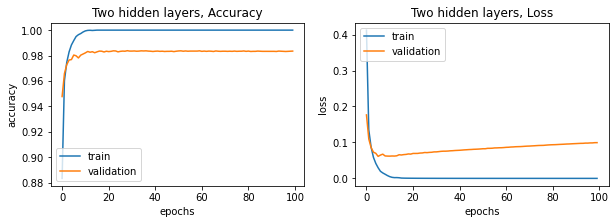

In [14]:
model = make_two_hidden_layers_model()
history_2HLM = run_and_report(model, 'Two hidden layers', 'two-hidden-layers', 
                              batch_size=comparison_batch_size, verbosity=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
 - 1s - loss: 0.9420 - accuracy: 0.7632 - val_loss: 0.4166 - val_accuracy: 0.8911
Epoch 2/100
 - 1s - loss: 0.3682 - accuracy: 0.8995 - val_loss: 0.3118 - val_accuracy: 0.9130
Epoch 3/100
 - 0s - loss: 0.2990 - accuracy: 0.9170 - val_loss: 0.2707 - val_accuracy: 0.9227
Epoch 4/100
 - 0s - loss: 0.2623 - accuracy: 0.9276 - val_loss: 0.2439 - val_accuracy: 0.9297
Epoch 5/100
 - 1s - loss: 0.2375 - accuracy: 0.9345 - val_loss: 0.2248 - val_accuracy: 0.9358
Epoch 6/100
 - 0s - loss: 0.2164 - accuracy: 0.9406 - val_loss: 0.2100 - val_accuracy: 0.9395
Epoch 7/100
 - 1s - loss: 0.1989 - accuracy: 0.9449 - val_loss: 0.1944 - val_accuracy: 0.9443
Epoch 8/100
 - 1s - loss: 0.1840 - accuracy: 0.9492 - val_loss: 0.1845 - val_accuracy: 0.9459
Epoch 9/100
 - 0s - loss: 0.1718 - accuracy: 0.9523 - val_loss: 0.1711 - val_accuracy: 0.9509
Epoch 10/100
 - 0s - loss: 0.1604 - accuracy: 0.9556 - val_loss: 0.1638 - val_accuracy: 0.9526
Epoch 11/

Epoch 87/100
 - 0s - loss: 0.0085 - accuracy: 0.9993 - val_loss: 0.0952 - val_accuracy: 0.9732
Epoch 88/100
 - 1s - loss: 0.0081 - accuracy: 0.9993 - val_loss: 0.0970 - val_accuracy: 0.9730
Epoch 89/100
 - 1s - loss: 0.0079 - accuracy: 0.9994 - val_loss: 0.0971 - val_accuracy: 0.9727
Epoch 90/100
 - 0s - loss: 0.0075 - accuracy: 0.9995 - val_loss: 0.0978 - val_accuracy: 0.9724
Epoch 91/100
 - 0s - loss: 0.0073 - accuracy: 0.9995 - val_loss: 0.0980 - val_accuracy: 0.9731
Epoch 92/100
 - 1s - loss: 0.0072 - accuracy: 0.9995 - val_loss: 0.0987 - val_accuracy: 0.9730
Epoch 93/100
 - 0s - loss: 0.0067 - accuracy: 0.9997 - val_loss: 0.1003 - val_accuracy: 0.9724
Epoch 94/100
 - 0s - loss: 0.0066 - accuracy: 0.9996 - val_loss: 0.0982 - val_accuracy: 0.9733
Epoch 95/100
 - 0s - loss: 0.0064 - accuracy: 0.9998 - val_loss: 0.1009 - val_accuracy: 0.9728
Epoch 96/100
 - 0s - loss: 0.0061 - accuracy: 0.9997 - val_loss: 0.1012 - val_accuracy: 0.9729
Epoch 97/100
 - 0s - loss: 0.0060 - accuracy: 0.99

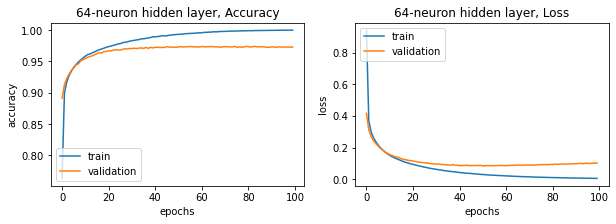

In [15]:
model = make_hidden_layer_n_neurons(64)
history_fc_64 = run_and_report(model, '64-neuron hidden layer', '64-neuron-hidden-layer', 
                               batch_size=comparison_batch_size, verbosity=2)

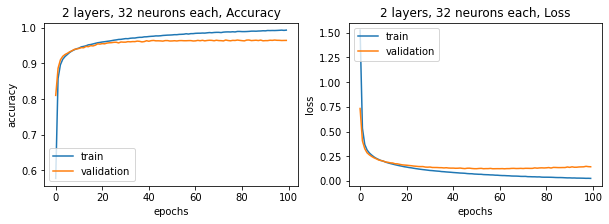

In [16]:
model = make_layers_model([32, 32], [False, False])
history_32_32 = run_and_report(model, '2 layers, 32 neurons each', '32-32-layers', 
                               batch_size=comparison_batch_size, verbosity=0)

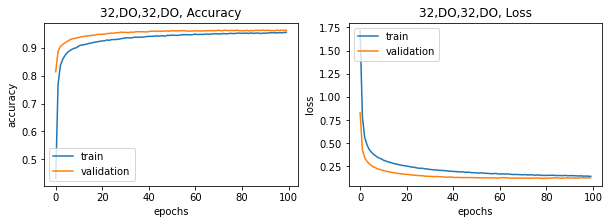

In [17]:
model = make_layers_model([32, 32], [True, True])
history_32_DO_32_DO = run_and_report(model, '32,DO,32,DO', '32-DO-32-DO', 
                               batch_size=comparison_batch_size, verbosity=0)

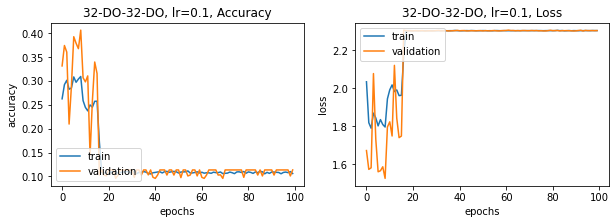

In [18]:
model = make_layers_model([32, 32], [True, True], learning_rate=0.1)
history_32_DO_32_DO_LR_p1 = run_and_report(model, '32-DO-32-DO, lr=0.1', '32-DO-32-DO-LR-p1', 
                               batch_size=comparison_batch_size, verbosity=0)

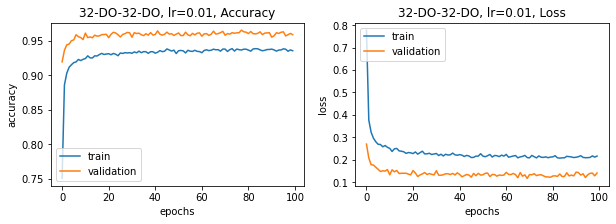

In [19]:
model = make_layers_model([32, 32], [True, True], learning_rate=0.01)
history_32_DO_32_DO_LR_p01 = run_and_report(model, '32-DO-32-DO, lr=0.01', '32-DO-32-DO-LR-p01', 
                               batch_size=comparison_batch_size, verbosity=0)